# 0. Preparation

Importing libraries, importing data, mounting to Google Drive (or utilize GPU). 

In [1]:
# importing libaries
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import pandas as pd
import cv2
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from keras.applications.vgg16 import VGG16

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
# %cd /content/gdrive/MyDrive/Kaggle/data
# !unzip \*.zip

# 1. Load Dataset

The dataset was adapted from [Kaggle](https://www.kaggle.com/sungtheillest/vehicledetected-stanford-cars-data-classes-folder), by combining 50% of the testing set to the training set to increase the number of training samples. The original 196 classes representing each vehicle's make and model were reduced to 49 classes representing only each vehicle's make.


As we import the data, we also apply several pre-processing techniques. We apply several data augmentation techniques, perform min-max scaling, normalize the image sizes to be 224 by 224, and finally split the data into a 75-25 train-validation split. 

We import the data using ImageDataGenerator objects to avoid exceeding RAM.

In [5]:
gen_params = {"rescale":1.0/255,
              "featurewise_center":False,
              "samplewise_center":False,
              "featurewise_std_normalization":False,
              "samplewise_std_normalization":False,
              "zca_whitening":False,
              "rotation_range":20,
              "width_shift_range":0.1,
              "height_shift_range":0.1,
              "shear_range":0.2,
              "zoom_range":0.1,
              "horizontal_flip":True,
              "fill_mode":'constant',
              "cval": 0,
              "validation_split":0.25}

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**gen_params)

test_params = {"rescale":1.0/255,}
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**test_params)


## Data generator for training images
train_generator = train_datagen.flow_from_directory('/content/gdrive/MyDrive/Kaggle/data/car_data/train/',
                                                    class_mode='categorical', batch_size = 32,
                                                    target_size=(224,224),color_mode='rgb',shuffle = True,subset='training')

val_generator = train_datagen.flow_from_directory('/content/gdrive/MyDrive/Kaggle/data/car_data/train/',
                                                    class_mode='categorical', batch_size = 32, 
                                                    target_size=(224,224),color_mode='rgb',shuffle = True,subset='validation')

test_generator = test_datagen.flow_from_directory('/content/gdrive/MyDrive/Kaggle/data/car_data/test/',
                                                    class_mode='categorical', batch_size = 32,
                                                    target_size=(224,224),color_mode='rgb',shuffle = True)

Found 9138 images belonging to 49 classes.
Found 3021 images belonging to 49 classes.
Found 4026 images belonging to 49 classes.


# 2. Dataset Exploration

The goal of this section is to investigate and visualize the dataset. 

## 2.1. Dataset Information

In this section, we create a table to briefly summarize the dataset. We investiage information such as the number of images, the size of each image, and the number of classes.

In [6]:
list_data = [train_generator.samples,
             val_generator.samples,
             test_generator.samples,
             train_generator.samples+val_generator.samples+test_generator.samples,
             train_generator.image_shape,
             len(np.unique(train_generator.classes))]

df = pd.DataFrame([list_data],
                  columns=['Number of training images','Number of validation images','Number of testing images','Total number of images','Size of each image','Number of Classes'],
                  index=['Value']).transpose()

display(df)

,Value
Number of training images,9138
Number of validation images,3021
Number of testing images,4026
Total number of images,16185
Size of each image,"(224, 224, 3)"
Number of Classes,49


## 2.2. Class Distribution

Next, we investigate the number of samples we have for each class. This information can be used to indicate if we have enough data per class, or if we have a large class imbalance.

In [7]:
from collections import Counter
train = Counter(train_generator.classes)
val = Counter(val_generator.classes)
test = Counter(test_generator.classes)
total = dict(train+val+test)
class_names = dict(train_generator.class_indices)
class_names = {v: k for k, v in class_names.items()}

In [8]:
class_df = pd.DataFrame([class_names,total]).transpose()
class_df.columns=['Make','Num Images']
class_df

,Make,Num Images
0,AM General,89
1,Acura,482
2,Aston Martin,314
3,Audi,1169
4,BMW,1055
5,Bentley,472
6,Bugatti,152
7,Buick,314
8,Cadillac,257
9,Chevrolet,1799


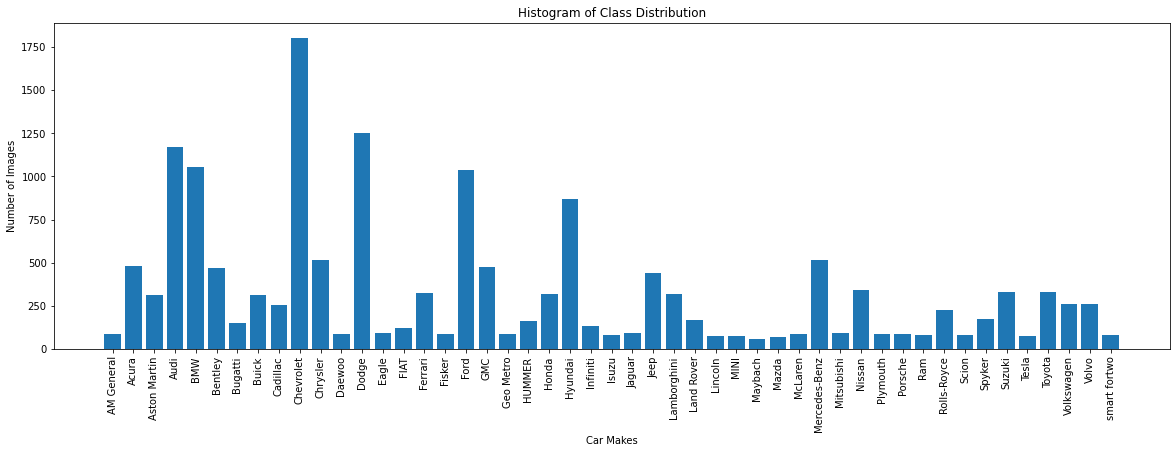

In [9]:
fig = plt.figure()
fig.set_size_inches(20,6)
plt.bar(class_df['Make'],class_df['Num Images'])
plt.xticks(rotation=90)
plt.xlabel("Car Makes")
plt.ylabel("Number of Images")
plt.title("Histogram of Class Distribution")
plt.show()

## 2.3. Data Visualization

Finally, we will visualize a few of the images in this dataset. 

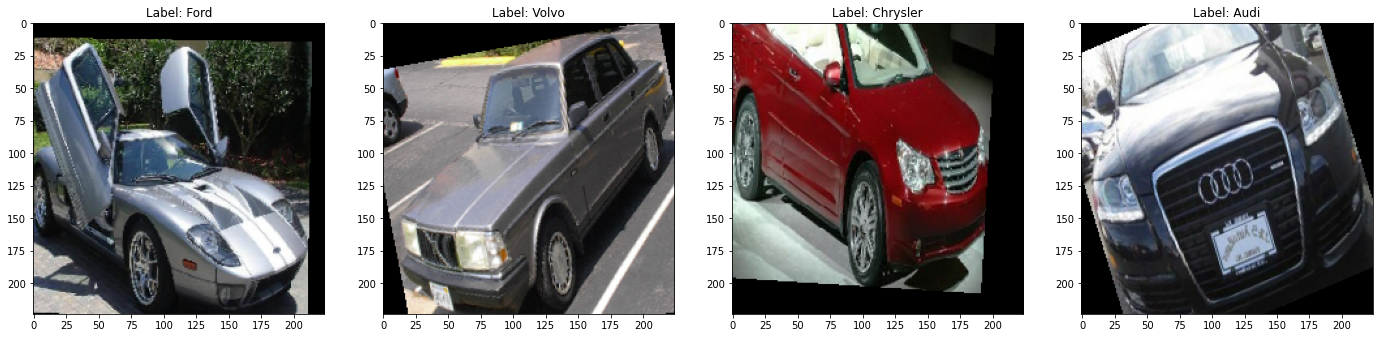

In [10]:
# Displaying some images from training set
plt.figure(figsize = (24,18))
Xbatch,Ybatch = train_generator.__getitem__(0)
for ii in range(4):
    plt.subplot(1,4,ii+1)
    plt.imshow((Xbatch[ii]- Xbatch[ii].min())/(Xbatch.max() - Xbatch[ii].min()), cmap = "gray")
    plt.title("Label: %s" %class_names[int(Ybatch[ii].argmax())])
plt.show()

# 3. Machine Learning Model

In this section, we leverage transfer learning to train a VGG16 model with weights pre-trained on the ImageNet dataset on the cars data, and then fine-tune the weights to our task. The justification for this architecture can be found in our final report.

## 3.1. Build Model

In this stage, we load the pre-trained VGG16 model without the top. We freeze the layers, and add a 49-neuron softmax prediction layer. 

In [11]:
def build_vgg16_transfer_learning_model(img_height=224,img_width=224,num_classes=49):

    # base model
    base_model = tf.keras.applications.VGG16(
        weights='imagenet',
        input_shape=(img_height, img_width, 3),
        include_top=False) 
    base_model.trainable = False

    # add the top
    input_image = tf.keras.Input(shape=(img_height, img_width, 3))
    x1 = base_model(input_image, training=False)
    x2 = tf.keras.layers.Flatten()(x1)
    out = tf.keras.layers.Dense(num_classes,activation = 'softmax')(x2)
    model = tf.keras.Model(inputs = input_image, outputs =out)
  
    #compile and return
    model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-4),loss='categorical_crossentropy',metrics=['accuracy'])
    
    return model

In [12]:
model = build_vgg16_transfer_learning_model()
model.summary()

58892288/58889256 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 49)                1229361   
Total params: 15,944,049
Trainable params: 1,229,361
Non-trainable params: 14,714,688
_________________________________________________________________


## 3.2. Model Training

Train the model with a batch size of 128, and 100 epochs.

In [15]:
model_name = "enel_645_team_14_project.h5"
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20)

monitor = tf.keras.callbacks.ModelCheckpoint(model_name, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=True,\
                                             mode='min')
# Learning rate schedule
def scheduler(epoch, lr):
    if epoch%4 == 0 and epoch!= 0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

In [ ]:
batch = 128
num_epochs = 100

history = model.fit(train_generator,
                    validation_data = val_generator,
                    epochs=num_epochs,
                    verbose=1,
                    batch_size=batch,
                    callbacks=[early_stop,monitor,lr_schedule])

Epoch 1/100
286/286 [==============================] - 167s 582ms/step - loss: 3.4192 - accuracy: 0.1199 - val_loss: 2.8033 - val_accuracy: 0.2526
Epoch 2/100
286/286 [==============================] - 163s 570ms/step - loss: 2.6397 - accuracy: 0.2940 - val_loss: 2.4467 - val_accuracy: 0.3244
Epoch 3/100
286/286 [==============================] - 162s 567ms/step - loss: 2.2685 - accuracy: 0.3882 - val_loss: 2.2142 - val_accuracy: 0.3919
Epoch 4/100
286/286 [==============================] - 163s 569ms/step - loss: 1.9909 - accuracy: 0.4719 - val_loss: 2.0934 - val_accuracy: 0.4085
Epoch 5/100
286/286 [==============================] - 163s 569ms/step - loss: 1.8057 - accuracy: 0.5233 - val_loss: 1.9592 - val_accuracy: 0.4777
Epoch 6/100
286/286 [==============================] - 163s 569ms/step - loss: 1.7033 - accuracy: 0.5612 - val_loss: 1.8948 - val_accuracy: 0.4916
Epoch 7/100
286/286 [==============================] - 162s 568ms/step - loss: 1.6509 - accuracy: 0.5772 - val_loss: 1

## 3.3. Model Fine-Tuning

After training the model, we unfreeze the layers and fine-tune the model with a very small learning rate. We again use a batch size of 128 and 100 epochs.

In [16]:
## finetune model
base_model = tf.keras.applications.VGG16(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(224,224,3),
    include_top=False) 
base_model.trainable = True
input_image = tf.keras.Input(shape=(224,224,3))
x1 = base_model(input_image, training=True)
x2 = tf.keras.layers.Flatten()(x1)
out = tf.keras.layers.Dense(49,activation = 'softmax')(x2)
model = tf.keras.Model(input_image, out)
print(model.summary())

model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-6),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.load_weights(model_name)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 49)                1229361   
Total params: 15,944,049
Trainable params: 15,944,049
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
batch = 128
num_epochs = 100
history_2 = model.fit(train_generator,
          validation_data = val_generator,
          epochs=num_epochs,
          verbose=1,
          batch_size=batch,
          callbacks=[early_stop,monitor,lr_schedule])

Epoch 1/100
286/286 [==============================] - 166s 574ms/step - loss: 1.1580 - accuracy: 0.6789 - val_loss: 1.3977 - val_accuracy: 0.6015
Epoch 2/100
286/286 [==============================] - 163s 570ms/step - loss: 0.9811 - accuracy: 0.7105 - val_loss: 1.3474 - val_accuracy: 0.6097
Epoch 3/100
286/286 [==============================] - 163s 570ms/step - loss: 0.8997 - accuracy: 0.7325 - val_loss: 1.2992 - val_accuracy: 0.6273
Epoch 4/100
286/286 [==============================] - 163s 568ms/step - loss: 0.8749 - accuracy: 0.7389 - val_loss: 1.2979 - val_accuracy: 0.6230
Epoch 5/100
286/286 [==============================] - 164s 572ms/step - loss: 0.8013 - accuracy: 0.7594 - val_loss: 1.2596 - val_accuracy: 0.6395
Epoch 6/100
286/286 [==============================] - 163s 569ms/step - loss: 0.7948 - accuracy: 0.7600 - val_loss: 1.2514 - val_accuracy: 0.6548
Epoch 7/100
286/286 [==============================] - 163s 570ms/step - loss: 0.7758 - accuracy: 0.7626 - val_loss: 1

## 3.4. Validation Curves

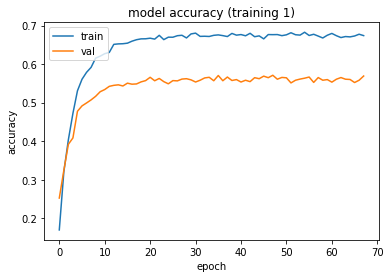

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy (training 1)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

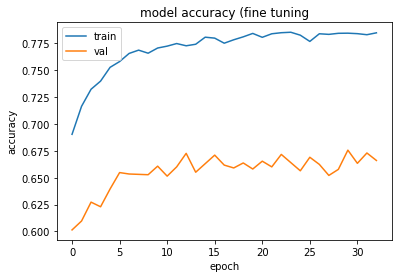

In [ ]:
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('model accuracy (fine tuning')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

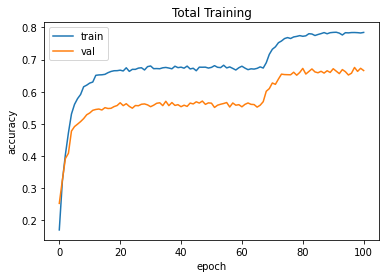

In [ ]:
acc_total = np.zeros(len(history.history['accuracy']) + len(history_2.history['accuracy']))
val_total = np.zeros(len(history.history['val_accuracy']) + len(history_2.history['val_accuracy']))

for i in range(len(history.history['accuracy'])):
  acc_total[i] = history.history['accuracy'][i]
  val_total[i] = history.history['val_accuracy'][i]
  
for j in range(len(history_2.history['accuracy'])):
  acc_total[j+len(history.history['accuracy'])] = history_2.history['accuracy'][j]
  val_total[j+len(history.history['val_accuracy'])] = history_2.history['val_accuracy'][j]



plt.plot(acc_total)
plt.plot(val_total)
plt.title('Total Training')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()  

# 4. Testing

In [ ]:
model.load_weights(model_name)
metrics = model.evaluate(test_generator)

126/126 [==============================] - 26s 209ms/step - loss: 1.0663 - accuracy: 0.7052


In [ ]:
max(history_2.history['val_accuracy'])

0.6756041049957275

In [ ]:
max(history_2.history['accuracy'])

0.785182774066925

## 4.1. Visualizing Predictions

Visualizing a few instances of where our model went wrong.

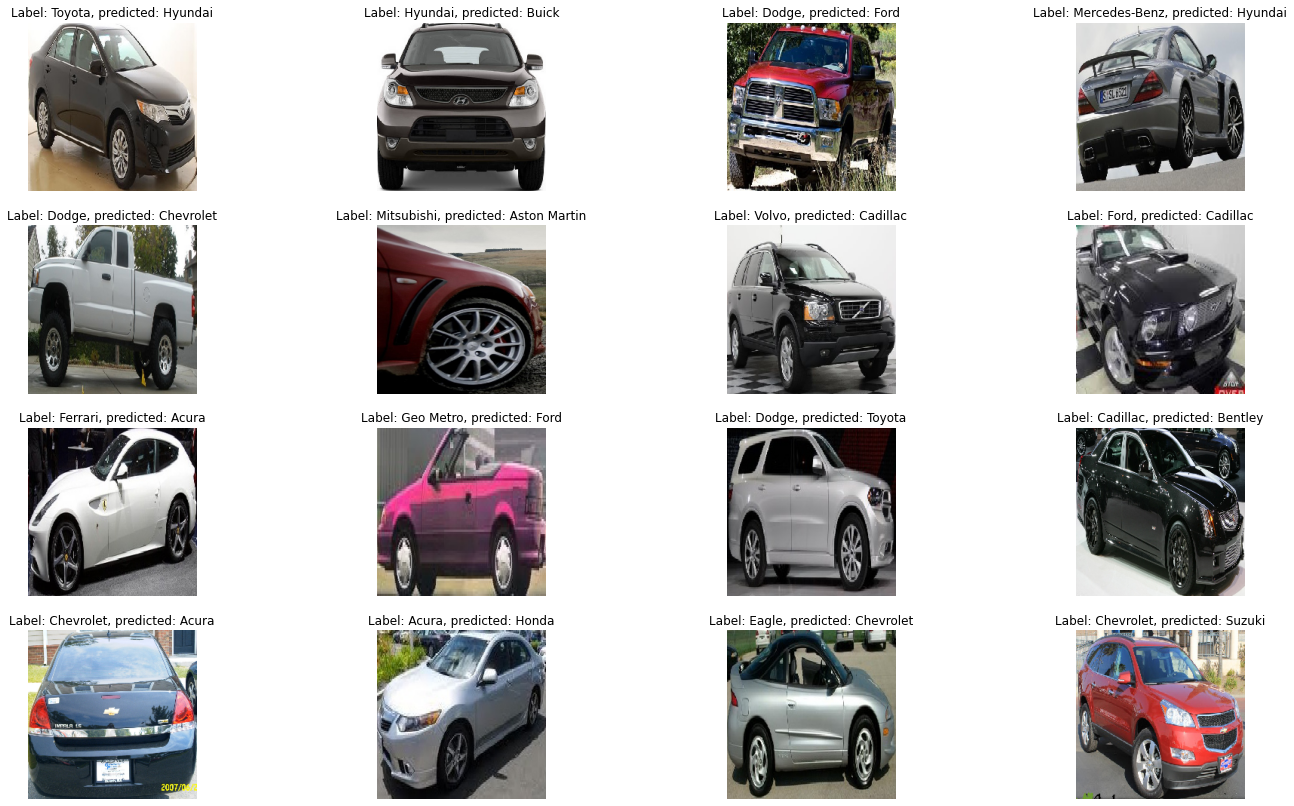

In [24]:
img = []
true_label = []
pred_label = []
for ii in range(2):
    Xbatch,Ybatch = test_generator.__getitem__(ii)
    Ybatch = Ybatch.argmax(axis = 1)
    Ypred = model.predict(Xbatch).argmax(axis = 1)
    wrong_indexes = np.where(Ypred != Ybatch)[0]
    for ii in wrong_indexes:
        img.append(Xbatch[ii])
        true_label.append(Ybatch[ii])
        pred_label.append(Ypred[ii])

columns = 4
rows = len(img)//columns + 1    
plt.figure(figsize = (24,18))
for ii in range(len(img)):
    plt.subplot(rows,columns,ii+1)
    plt.imshow(img[ii], cmap = "gray")
    plt.axis("off")
    plt.title("Label: %s, predicted: %s" %(class_names[true_label[ii]]\
                                            ,class_names[pred_label[ii]]))
plt.show()